Using Colab cache for faster access to the 'drive-digital-retinal-images-for-vessel-extraction' dataset.
Dataset downloaded at: /kaggle/input/drive-digital-retinal-images-for-vessel-extraction
Testing Window Sizes

Sauvola - Window: 15 Sensitivity: 0.00948982074782647
Niblack - Window: 15 Sensitivity: 0.9039662584147522

Sauvola - Window: 25 Sensitivity: 0.023846216238128052
Niblack - Window: 25 Sensitivity: 0.9144699489005943

Sauvola - Window: 35 Sensitivity: 0.029523886771015685
Niblack - Window: 35 Sensitivity: 0.9084678400515417

Best Sauvola Window: 35
Best Niblack Window: 25

Final Results
Sauvola Sensitivity: 0.029523886771015685
Niblack Sensitivity: 0.9144699489005943
Niblack performs better for thin vessel detection.


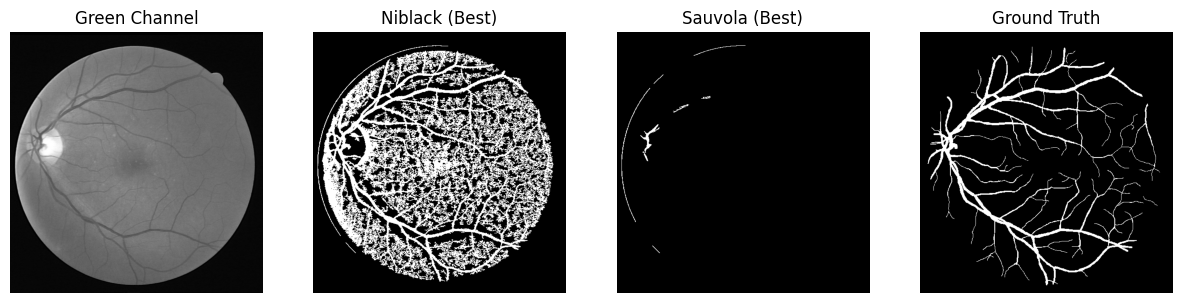

In [7]:
!pip install -q kagglehub

import kagglehub
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.filters import threshold_niblack, threshold_sauvola
from skimage.morphology import remove_small_objects

dataset_path = kagglehub.dataset_download("andrewmvd/drive-digital-retinal-images-for-vessel-extraction")
print("Dataset downloaded at:", dataset_path)

training_path = os.path.join(dataset_path, "DRIVE", "training")

images_path = os.path.join(training_path, "images")
mask_path = os.path.join(training_path, "mask")
gt_path = os.path.join(training_path, "1st_manual")

image_file = "21_training.tif"

image = cv2.imread(os.path.join(images_path, image_file))
fov = cv2.imread(os.path.join(mask_path, "21_training_mask.gif"), 0)
gt = cv2.imread(os.path.join(gt_path, "21_manual1.gif"), 0)

# Convert masks to binary
_, fov = cv2.threshold(fov, 127, 1, cv2.THRESH_BINARY)
_, gt = cv2.threshold(gt, 127, 1, cv2.THRESH_BINARY)

# Use green channel (best contrast)
green = image[:, :, 1]

def sensitivity(pred, gt):
    pred = pred.astype(bool)
    gt = gt.astype(bool)
    tp = np.logical_and(pred, gt).sum()
    fn = np.logical_and(~pred, gt).sum()
    return tp / (tp + fn + 1e-8)

window_sizes = [15, 25, 35]

print("Testing Window Sizes\n")

best_sens_sauvola = 0
best_window_sauvola = 25

best_sens_niblack = 0
best_window_niblack = 25

for w in window_sizes:

    # ---- Sauvola ----
    thresh_s = threshold_sauvola(green, window_size=w, k=0.3)
    mask_s = green < thresh_s
    mask_s = np.logical_and(mask_s, fov)
    mask_s = remove_small_objects(mask_s, min_size=30)
    sens_s = sensitivity(mask_s, gt)

    print("Sauvola - Window:", w, "Sensitivity:", sens_s)

    if sens_s > best_sens_sauvola:
        best_sens_sauvola = sens_s
        best_window_sauvola = w

    # ---- Niblack ----
    thresh_n = threshold_niblack(green, window_size=w, k=-0.2)
    mask_n = green < thresh_n
    mask_n = np.logical_and(mask_n, fov)
    mask_n = remove_small_objects(mask_n, min_size=30)
    sens_n = sensitivity(mask_n, gt)

    print("Niblack - Window:", w, "Sensitivity:", sens_n)
    print()

    if sens_n > best_sens_niblack:
        best_sens_niblack = sens_n
        best_window_niblack = w

print("Best Sauvola Window:", best_window_sauvola)
print("Best Niblack Window:", best_window_niblack)

# Final Sauvola
thresh_s_final = threshold_sauvola(green, window_size=best_window_sauvola, k=0.3)
sauvola_mask = green < thresh_s_final
sauvola_mask = np.logical_and(sauvola_mask, fov)
sauvola_mask = remove_small_objects(sauvola_mask, min_size=30)

# Final Niblack
thresh_n_final = threshold_niblack(green, window_size=best_window_niblack, k=-0.2)
niblack_mask = green < thresh_n_final
niblack_mask = np.logical_and(niblack_mask, fov)
niblack_mask = remove_small_objects(niblack_mask, min_size=30)

final_sens_s = sensitivity(sauvola_mask, gt)
final_sens_n = sensitivity(niblack_mask, gt)

print("\nFinal Results")
print("Sauvola Sensitivity:", final_sens_s)
print("Niblack Sensitivity:", final_sens_n)

if final_sens_s > final_sens_n:
    print("Sauvola performs better for thin vessel detection.")
else:
    print("Niblack performs better for thin vessel detection.")

plt.figure(figsize=(15,4))

plt.subplot(1,4,1)
plt.imshow(green, cmap='gray')
plt.title("Green Channel")
plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(niblack_mask, cmap='gray')
plt.title("Niblack (Best)")
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(sauvola_mask, cmap='gray')
plt.title("Sauvola (Best)")
plt.axis('off')

plt.subplot(1,4,4)
plt.imshow(gt, cmap='gray')
plt.title("Ground Truth")
plt.axis('off')

plt.show()
